In [29]:
using Pkg

In [30]:
Pkg.activate(".")

  Activating project at `~/phome/julia/AutoMLPipeline.jl/AutoAI`


In [31]:
using AutoAI
using Statistics
using Random
using DataFrames: DataFrame
using Plots
using CSV

In [32]:
using Distributed
nprocs()==1 && addprocs(exeflags=["--project=$(Base.active_project())"])
@everywhere using AutoAI

In [33]:
function ad1(df)
  dfres = DataFrame()
  for learner in keys(AutoAI.CaretAnomalyDetectors.caretadlearner_dict)
    model = CaretAnomalyDetector(learner)
    res = fit_transform!(model, df)
    mname = string(learner)
    dfres = hcat(dfres, DataFrame(mname => res; makeunique=true))
  end
  return dfres
end

ad1 (generic function with 1 method)

In [34]:
function ad2(df)
  clf1 = SKAnomalyDetector("IsolationForest")
  clf2 = SKAnomalyDetector("EllipticEnvelope")
  clf3 = SKAnomalyDetector("OneClassSVM")
  clf4 = SKAnomalyDetector("LocalOutlierFactor")
  res1 = fit_transform!(clf1, df)
  res2 = fit_transform!(clf2, df)
  res3 = fit_transform!(clf3, df)
  res4 = fit_transform!(clf4, df)
  return DataFrame(iso=res1, eli=res2, osvm=res3, lcl=res4)
end


ad2 (generic function with 1 method)

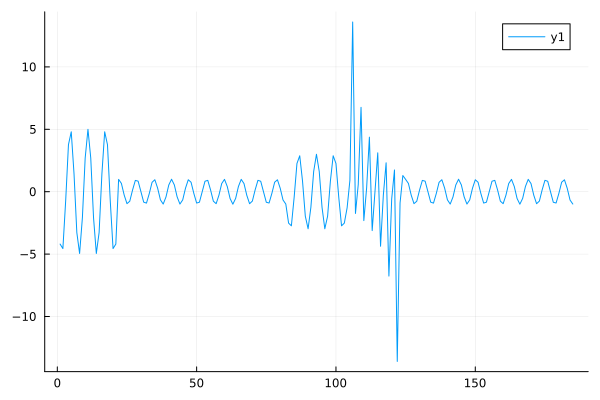

In [53]:
df1 = vcat(5*cos.(-10:10),sin.(-30:30),3*cos.(-10:10),2*tan.(-10:10),sin.(-30:30)) |> x -> DataFrame([x], :auto);
plot(df1.x1)

### Anomaly Detection by AutoML

In [36]:
function combine(df)
    a=hcat(ad1(df),ad2(df))
    hcat(a,mean.(eachrow(a)))
end

combine (generic function with 1 method)

In [37]:
ydf1=combine(df1)

PythonCall.Core.Py


185×17 DataFrame
 Row │ sod    iforest  histogram  mcd    sos    abod   svm    cluster  pca     ⋯
     │ Int64  Int64    Int64      Int64  Int64  Int64  Int64  Int64    Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0        0          0      0      0      0      0        0      1   ⋯
   2 │     0        0          0      0      0      0      0        0      1
   3 │     0        0          0      0      0      0      0        0      0
   4 │     0        0          0      0      0      1      0        0      0
   5 │     0        1          0      1      0      0      1        0      0   ⋯
   6 │     0        0          0      0      0      0      0        0      0
   7 │     0        0          0      0      0      0      0        0      0
   8 │     0        1          0      1      0      1      1        0      1
   9 │     0        0          0      0      0      0      0        0      0   ⋯
  10 │     0        0          0      0      0      0      0        1      0
  11 │     0        1          0      1      0      0      1        1      0
  ⋮  │   ⋮       ⋮         ⋮        ⋮      ⋮      ⋮      ⋮       ⋮       ⋮     ⋱
 176 │     0        0          0      0      0      0      0        0      0
 177 │     0        0          0      0      0      0      0        0      0   ⋯
 178 │     0        0          0      0      0      0      0        0      0
 179 │     0        0          0      0      0      0      0        0      0
 180 │     0        0          0      0      0      0      0        0      0
 181 │     0        0          0      0      0      0      0        0      0   ⋯
 182 │     0        0          0      0      0      0      0        0      0
 183 │     0        0          0      0      0      0      0        0      0
 184 │     0        0          0      0      0      0      0        0      0
 185 │     0        0          0      0      0      0      0        0      0   ⋯
                                                  8 columns and 164 rows omitted

#### Find anomalies based on fractions of votes among detectors

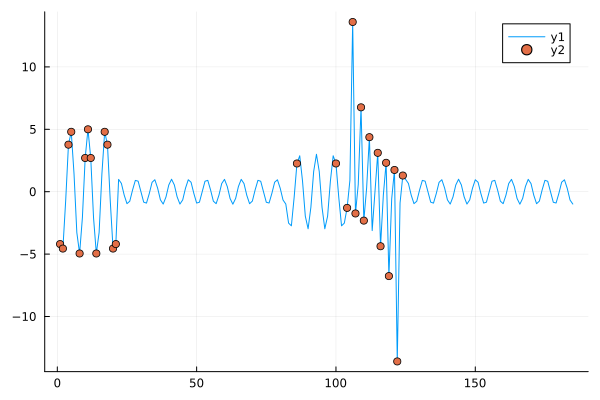

In [66]:
ndx=findall(x->x>=0.2,ydf1.x1)
Plots.plot(df1.x1)
scatter!(ndx,df1.x1[ndx])

### Time Series Prediction by AutoML

In [43]:
Random.seed!(10)
df2 = sin.(-30:30) |> x -> DataFrame([x], :auto)
bmodel = CaretTSPredictor("auto", Dict(:verbose => true,:forecast_horizon=>10))
bestres = fit_transform!(bmodel, df2)

                                                             Model    MASE  \
auto_arima                                              Auto ARIMA  0.0027   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending  0.3848   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending  0.4035   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...  0.4584   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...  0.6242   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending  0.7106   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending  0.8170   
arima                                                        ARIMA  0.8371   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending  0.8474   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...  0.8764   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending  1.0097   
exp_smooth                                   Exponential Smoothi

[ Info: evaluating the best model: AutoARIMA(random_state=123, sp=6, suppress_warnings=True)


10-element Vector{Float64}:
 -0.4037
  0.5523
  1.0008
  0.529
 -0.4296
 -0.9936
 -0.6433
  0.2999
  0.9683
  0.7459

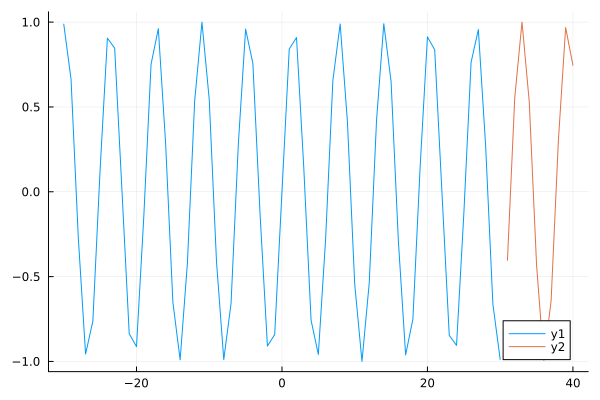

In [44]:
x=-30:30
y=sin.(x)
ll=length(y)
plot(x,y)
plot!(31:31+length(bestres)-1,bestres)

### AutoClassification and AutoRegression

#### Get the data

In [45]:
df3 = CSV.File("./test/iris.csv") |> DataFrame
first(df3,5)

5×5 DataFrame
 Row │ SepalLength  SepalWidth  PetalLength  PetalWidth  Species  
     │ Float64      Float64     Float64      Float64     String15 
─────┼────────────────────────────────────────────────────────────
   1 │         5.1         3.5          1.4         0.2  setosa
   2 │         4.9         3.0          1.4         0.2  setosa
   3 │         4.7         3.2          1.3         0.2  setosa
   4 │         4.6         3.1          1.5         0.2  setosa
   5 │         5.0         3.6          1.4         0.2  setosa

### AutoClassification

In [46]:
X = df3[:, 1:end-1]
Y = df3[:, end] |> collect
autoclass = AutoClassification()
Yhat = fit_transform!(autoclass, X, Y);

      From worker 3:	fold: 1, 0.9777777777777779
      From worker 2:	fold: 1, 0.7963051441312311
      From worker 3:	fold: 2, 0.9277777777777777
      From worker 4:	fold: 1, 0.8968253968253969
      From worker 3:	fold: 3, 0.9166666666666666
      From worker 3:	errors: 0
      From worker 2:	fold: 2, 0.9743589743589745
      From worker 4:	fold: 2, 0.9629629629629629
      From worker 2:	fold: 3, 1.0
      From worker 2:	errors: 0
      From worker 4:	fold: 3, 0.868937048503612
      From worker 4:	errors: 0
modelsperf = 3×4 DataFrame
 Row │ Description            mean      sd         Pipeline
     │ String                 Float64   Float64    Pipeline
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ (rb |> pca) |> rbfsvc  0.940741  0.0325526  Pipeline("linearpipeline_3Jx", D…
   2 │ (rb |> pca) |> rfc     0.923555  0.110945   Pipeline("linearpipeline_8bT", D…
   3 │ (rb |> pca) |> gbc     0.909575  0.0482922  Pipeline("linearpipeline_2Gu

#### Description of the best pipeline

In [47]:
autoclass.model[:bestpipeline].model[:description]

"(norm |> pca) + (norm |> pca) |> rbfsvc"

#### Get the pipeline functional expression

In [48]:
autoclass.model[:bestpipeline]

Pipeline("linearpipeline_DZb", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :description => "(norm |> pca) + (norm |> pca) |> rbfsvc", :name => "linearpipeline_DZb", :machines => Machine[Pipeline("linearpipeline_ZZv_mbh", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_ZZv_mbh", :machines => Machine[ComboPipeline("combopipeline_ZBD_Zf1", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "combopipeline_ZBD_Zf1", :machines => Machine[Pipeline("linearpipeline_RdR_31p", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_RdR_31p", :machines => Machine[CatFeatureSelector("catf_Qv1_3pr", Dict{Symbol, Any}(:name => "catf_Qv1_3pr", :nominal_columns => Int64[])), OneHotEncoder("ohe_dUw_HSD", Dict{Symbol, Any}(:nominal_column_values_map => Dict{Int64, Any}(), :name => "ohe_dUw_HSD", :nominal_columns => Int64[]))])), NumFeatureSelector("numf_QNa_UvZ", Dict{Symbol, Any}(:name => "numf_QNa_UvZ", :numcols => [1, 

### AutoRegression

In [49]:
X = df3[:, [1, 2, 3, 5]]
Y = df3[:, 4] |> collect
autoreg = AutoRegression()
Yhat = fit_transform!(autoreg, X, Y);

      From worker 3:	fold: 1, 0.025678285955300223
      From worker 4:	fold: 1, 0.04199897009258875
      From worker 2:	fold: 1, 0.03648911070000007
      From worker 4:	fold: 2, 0.0387417369431221
      From worker 2:	fold: 2, 0.025974528399999922
      From worker 4:	fold: 3, 0.07113385133890034
      From worker 4:	errors: 0
      From worker 2:	fold: 3, 0.06955093367777772
      From worker 2:	errors: 0
      From worker 3:	fold: 2, 0.03531033306215876
      From worker 3:	fold: 3, 0.034977666713499896
      From worker 3:	errors: 0
modelsperf = 3×4 DataFrame
 Row │ Description         mean       sd          Pipeline
     │ String              Float64    Float64     Pipeline
─────┼──────────────────────────────────────────────────────────────────────────────
   1 │ (rb |> pca) |> svr  0.0319888  0.00546756  Pipeline("linearpipeline_Uko", D…
   2 │ (rb |> pca) |> rfr  0.0440049  0.0227396   Pipeline("linearpipeline_LAO", D…
   3 │ (rb |> pca) |> gbr  0.0506249  0.0178358   Pipelin

#### Description of the best Regression Pipeline

In [50]:
autoreg.model[:bestpipeline].model[:description]

"(pt |> pca) |> svr"

#### Best Pipeline Function description

In [51]:
autoreg.model[:bestpipeline]

Pipeline("linearpipeline_0gv", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :description => "(pt |> pca) |> svr", :name => "linearpipeline_0gv", :machines => Machine[Pipeline("linearpipeline_UPc_Zu0", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_UPc_Zu0", :machines => Machine[ComboPipeline("combopipeline_rRg_bOt", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "combopipeline_rRg_bOt", :machines => Machine[Pipeline("linearpipeline_Wgr_M5g", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_Wgr_M5g", :machines => Machine[CatFeatureSelector("catf_f61_htF", Dict{Symbol, Any}(:name => "catf_f61_htF", :nominal_columns => [4])), OneHotEncoder("ohe_iCH_E9X", Dict{Symbol, Any}(:nominal_column_values_map => Dict{Int64, Any}(1 => String15["setosa", "versicolor", "virginica"]), :name => "ohe_iCH_E9X", :nominal_columns => [1]))])), NumFeatureSelector("numf_hNh_45V", Dict{Symbol, Any}(:name => "numf_hNh_4